### Training of modified U-Net for Optic Disc on DRISHTI-GS database (cross-validation fold #0).

512 px cropped by Optic Disc area and resized to 128 px images were used.

You can either train your model or upload a pre-trained one from:
*../models_weights/02.03,13:57,OD Cup, U-Net light on DRISHTI-GS 512 px cropped to OD 128 px fold 0, SGD, log_dice loss/last_checkpoint.hdf5*

In [1]:
%load_ext autoreload
%autoreload 2

In [54]:
import os
import glob
from datetime import datetime
import scipy as sp
import scipy.ndimage
import numpy as np
import pandas as pd
import tensorflow as tf
import skimage
import skimage.exposure
import skimage.transform
from sklearn.model_selection import KFold
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
import h5py
from tqdm import tqdm_notebook
from IPython.display import display
from model import *

In [43]:
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, \
    Conv2D, MaxPooling2D, ZeroPadding2D, Input, Embedding, \
    Lambda, UpSampling2D, Cropping2D, Concatenate
from keras.utils import np_utils
from keras.optimizers import SGD, Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau, CSVLogger
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K

In [44]:
print('Keras version:', keras.__version__)
print('TensorFlow version:', tf.__version__)

Keras version: 2.3.1
TensorFlow version: 1.14.0


In [30]:
K.set_image_data_format('channels_first')

In [31]:
h5f = h5py.File(os.path.join(os.path.dirname(os.getcwd()), 'data', 'hdf5_datasets', 'DRISHTI_GS.hdf5'), 'r')

In [32]:
model = get_unet_light(img_rows=128, img_cols=128)
model.compile(optimizer=SGD(lr=1e-4, momentum=0.95),
              loss=log_dice_loss,
              metrics=[mean_IOU_gpu, dice_metric])

C:\Users\Rosana\Documents\Mestrado\dissertacao\unet\scripts\model.py:105: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


#### DRISHTI-GS

Accessing data, preparing train/validation sets division:

In [34]:
img_train = h5f['DRISHTI-GS/512 px/images']
cup_train = h5f['DRISHTI-GS/512 px/cup']
disc_train = h5f['DRISHTI-GS/512 px/disc']
disc_locations = h5f['DRISHTI-GS/512 px/disc_locations']

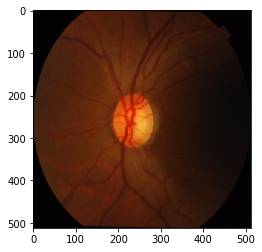

(50, 512, 512, 3)


In [35]:
plt.imshow(img_train[40])
plt.show()
print(img_train.shape)

In [36]:
img_train, cup_train, disc_train, disc_locations

(<HDF5 dataset "images": shape (50, 512, 512, 3), type "|u1">,
 <HDF5 dataset "cup": shape (50, 512, 512, 1), type "|u1">,
 <HDF5 dataset "disc": shape (50, 512, 512, 1), type "|u1">,
 <HDF5 dataset "disc_locations": shape (50, 4), type "<i8">)

#### Generator of augmented data:

Testing the data generator and generator for augmented data:

In [55]:
gen = data_generator(img_train, cup_train, disc_locations, 128, 'train', batch_size=1)
batch = next(gen)

C:\ProgramData\Anaconda3\lib\site-packages\skimage\util\dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


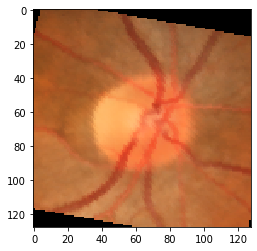

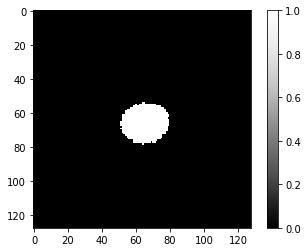

In [57]:
fig = plt.imshow(np.rollaxis(batch[0][0], 0, 3))
plt.show()
plt.imshow(batch[1][0][0], cmap=plt.cm.Greys_r); plt.colorbar(); plt.show()

In [59]:
arch_name = "OD Cup, U-Net light on DRISHTI-GS 512 px cropped to OD 128 px fold 0, SGD, log_dice loss"
weights_folder = os.path.join(os.path.dirname(os.getcwd()), 'models_weights',
                              '{}'.format(arch_name))

In [60]:
def folder(folder_name):
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)
    return folder_name

In [61]:
img_test = h5f['DRISHTI-GS-test/512 px/images']
cup_test = h5f['DRISHTI-GS-test/512 px/cup']
disc_test = h5f['DRISHTI-GS-test/512 px/disc']
disc_locations_test = h5f['DRISHTI-GS-test/512 px/disc_locations']

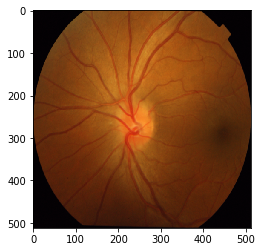

51


In [63]:
plt.imshow(img_test[50])
plt.show()
print(len(img_test))

In [65]:
X_valid, Y_valid = next(data_generator(img_test, cup_test, disc_locations, train_or_test='test', batch_size=100, stationary=True))

### Training

If a pretrained model needs to be used, first run "Loading model" section below and then go the "Comprehensive visual check", skipping this section.

In [67]:
history = model.fit_generator(data_generator(img_train, cup_train, disc_locations, train_or_test='train', batch_size=1), 
                              steps_per_epoch=99,
                              max_queue_size=1,                    
                              validation_data=(X_valid, Y_valid),                              
                              epochs=500, verbose=1,                              
                              callbacks=[CSVLogger(os.path.join(folder(weights_folder), 'training_log_cup_color.csv')),
                                         ModelCheckpoint(os.path.join(folder(weights_folder),
                                               'last_checkpoint_cup_color.hdf5'),
                                               monitor='val_loss', mode='min', save_best_only=True, 
                                               save_weights_only=False, verbose=0)])

C:\ProgramData\Anaconda3\lib\site-packages\skimage\util\dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


Epoch 1/1
99/99 [==============================] - 33s 331ms/step - loss: 1.5347 - mean_IOU_gpu: 0.0420 - dice_metric: 0.0800 - val_loss: 1.5274 - val_mean_IOU_gpu: 0.0000e+00 - val_dice_metric: 0.0000e+00


### Visual check

image #0


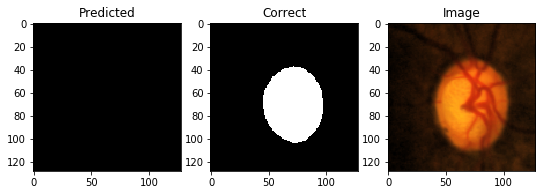

IOU: 0.0
Dice: 0.0
image #1


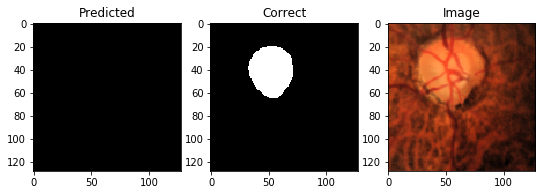

IOU: 0.0
Dice: 0.0
image #2


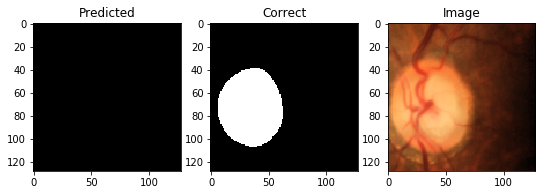

IOU: 0.0
Dice: 0.0
image #3


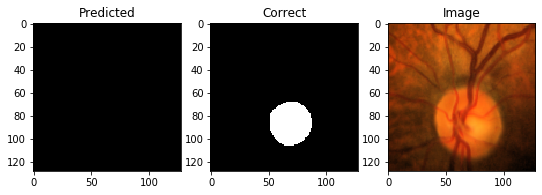

IOU: 0.0
Dice: 0.0
image #4


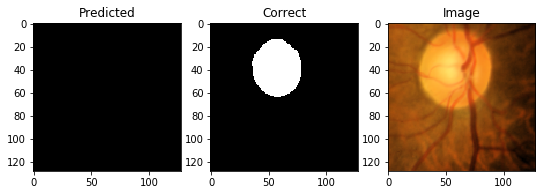

IOU: 0.0
Dice: 0.0
image #5


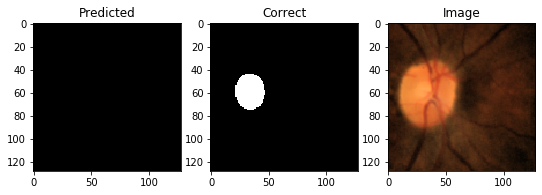

IOU: 0.0
Dice: 0.0
image #6


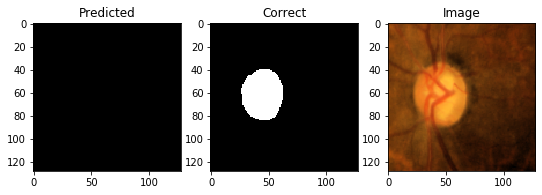

IOU: 0.0
Dice: 0.0
image #7


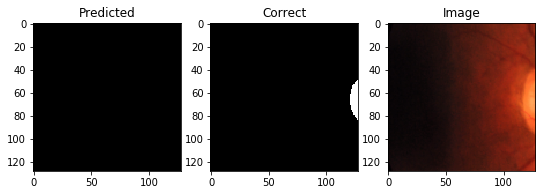

IOU: 0.0
Dice: 0.0
image #8


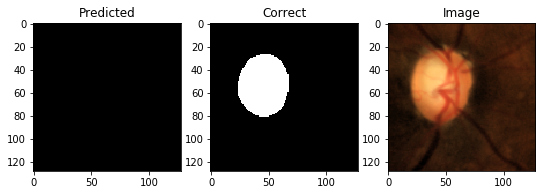

IOU: 0.0
Dice: 0.0
image #9


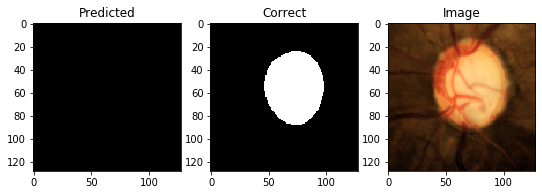

IOU: 0.0
Dice: 0.0
image #10


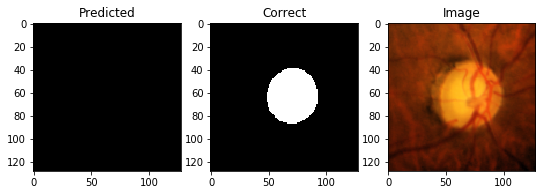

IOU: 0.0
Dice: 0.0
image #11


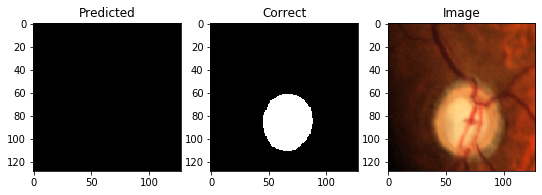

IOU: 0.0
Dice: 0.0
image #12


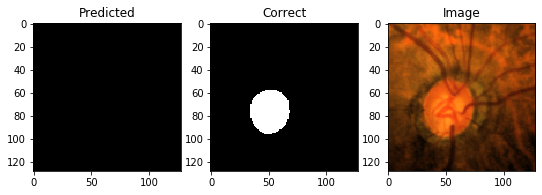

IOU: 0.0
Dice: 0.0
image #13


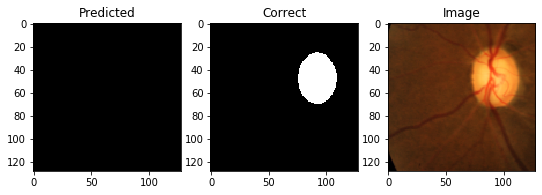

IOU: 0.0
Dice: 0.0
image #14


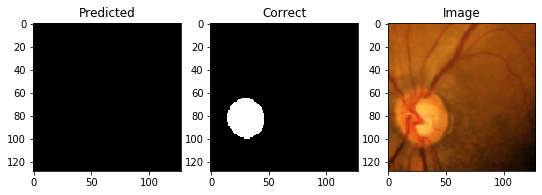

IOU: 0.0
Dice: 0.0
image #15


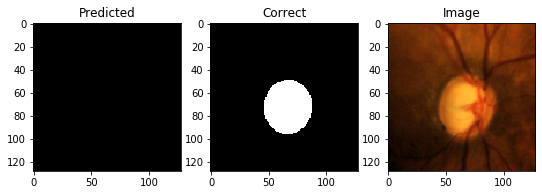

IOU: 0.0
Dice: 0.0
image #16


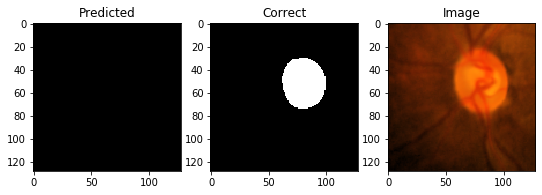

IOU: 0.0
Dice: 0.0
image #17


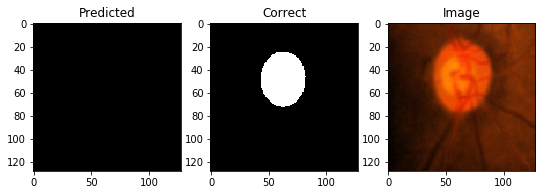

IOU: 0.0
Dice: 0.0
image #18


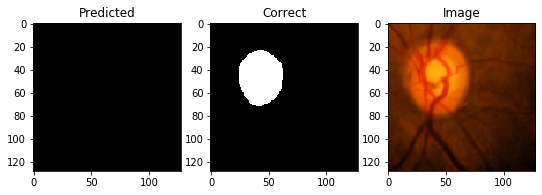

IOU: 0.0
Dice: 0.0
image #19


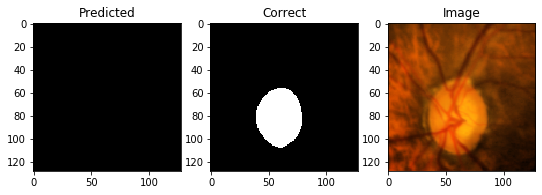

IOU: 0.0
Dice: 0.0
image #20


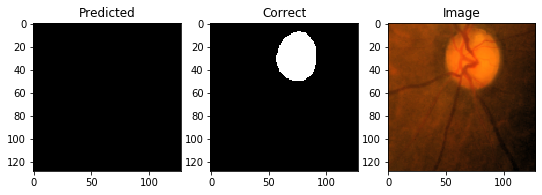

IOU: 0.0
Dice: 0.0
image #21


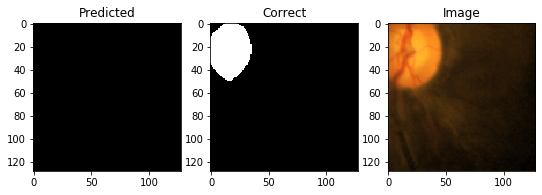

IOU: 0.0
Dice: 0.0
image #22


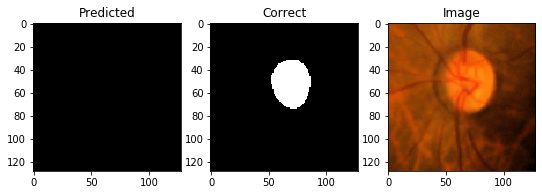

IOU: 0.0
Dice: 0.0
image #23


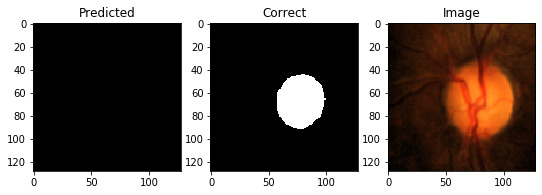

IOU: 0.0
Dice: 0.0
image #24


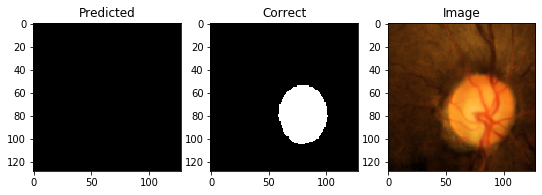

IOU: 0.0
Dice: 0.0
image #25


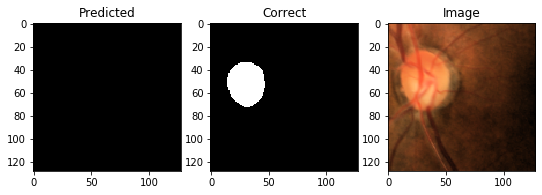

IOU: 0.0
Dice: 0.0
image #26


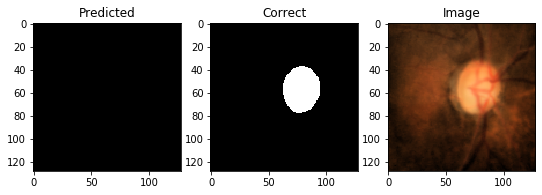

IOU: 0.0
Dice: 0.0
image #27


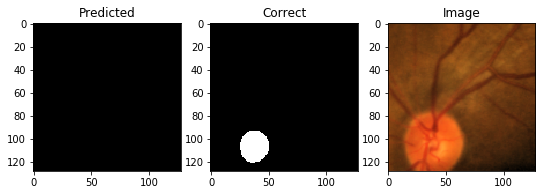

IOU: 0.0
Dice: 0.0
image #28


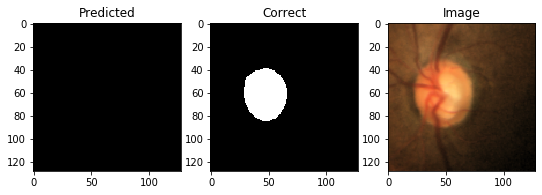

IOU: 0.0
Dice: 0.0
image #29


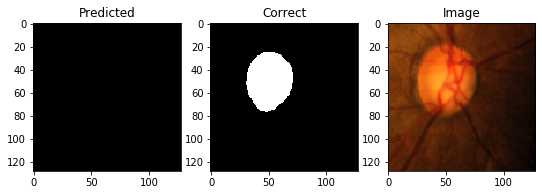

IOU: 0.0
Dice: 0.0
image #30


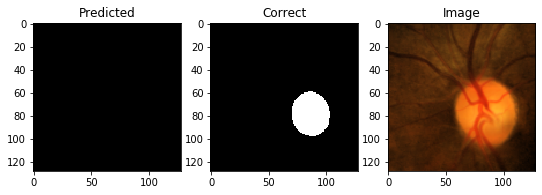

IOU: 0.0
Dice: 0.0
image #31


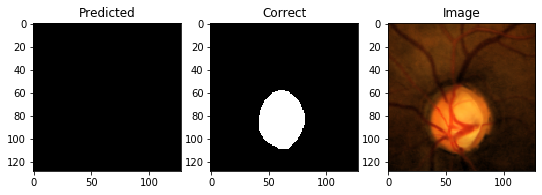

IOU: 0.0
Dice: 0.0
image #32


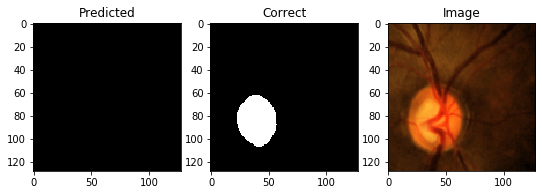

IOU: 0.0
Dice: 0.0
image #33


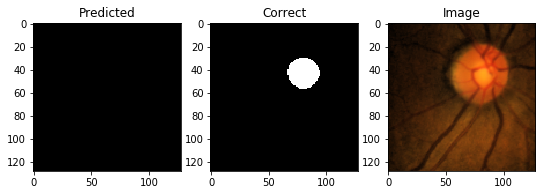

IOU: 0.0
Dice: 0.0
image #34


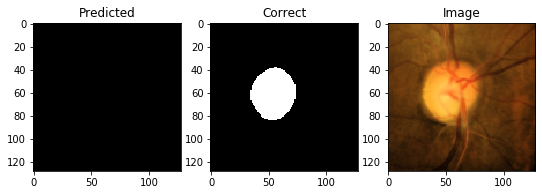

IOU: 0.0
Dice: 0.0
image #35


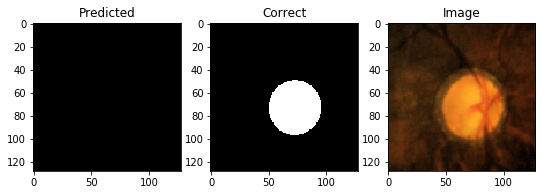

IOU: 0.0
Dice: 0.0
image #36


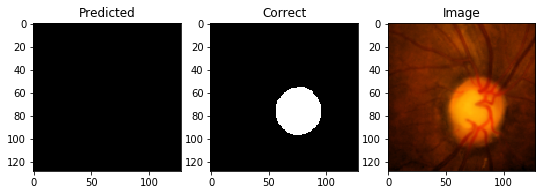

IOU: 0.0
Dice: 0.0
image #37


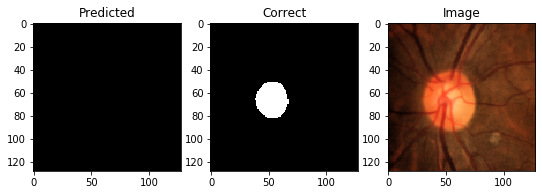

IOU: 0.0
Dice: 0.0
image #38


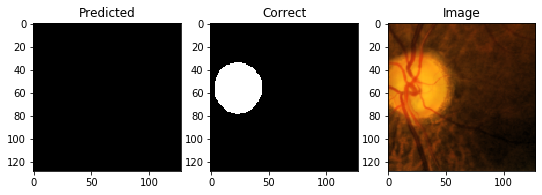

IOU: 0.0
Dice: 0.0
image #39


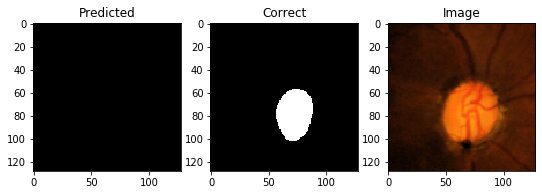

IOU: 0.0
Dice: 0.0
image #40


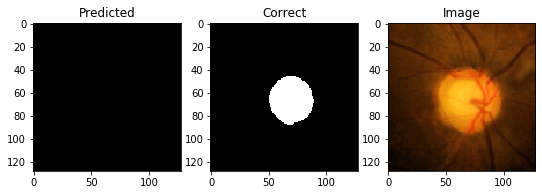

IOU: 0.0
Dice: 0.0
image #41


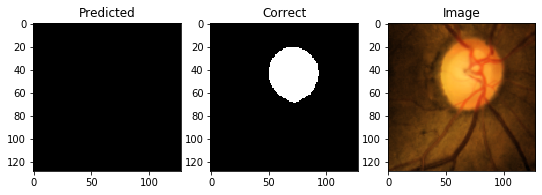

IOU: 0.0
Dice: 0.0
image #42


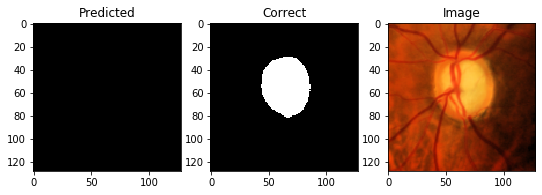

IOU: 0.0
Dice: 0.0
image #43


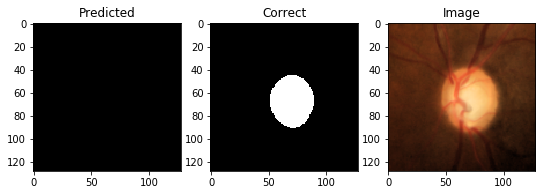

IOU: 0.0
Dice: 0.0
image #44


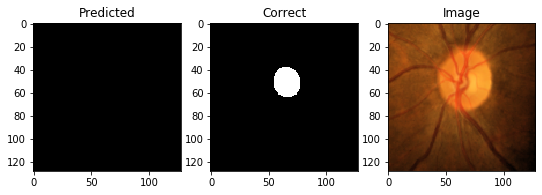

IOU: 0.0
Dice: 0.0
image #45


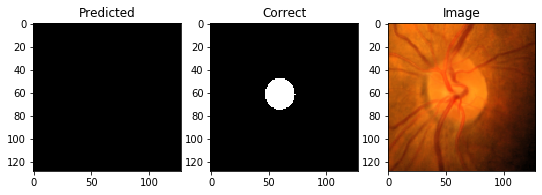

IOU: 0.0
Dice: 0.0
image #46


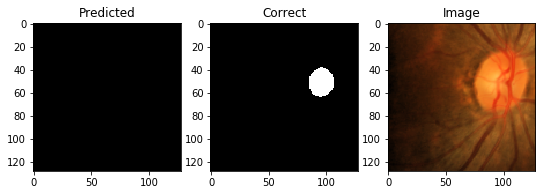

IOU: 0.0
Dice: 0.0
image #47


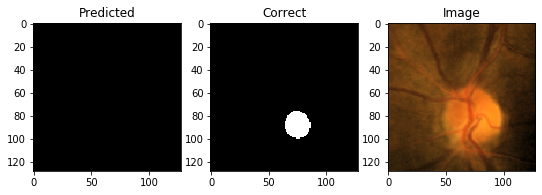

IOU: 0.0
Dice: 0.0
image #48


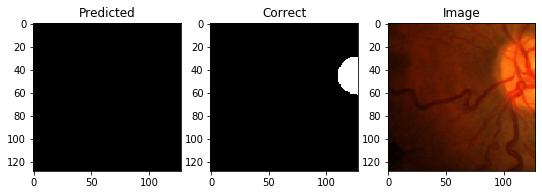

IOU: 0.0
Dice: 0.0
image #49


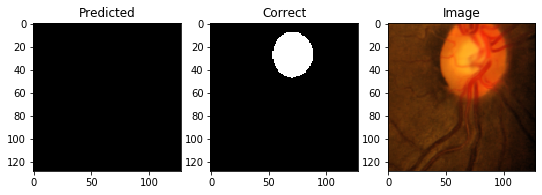

IOU: 0.0
Dice: 0.0


In [68]:
pred_iou, pred_dice = [], []
pred_cup = []

for i, img_no in enumerate(test_idx):
    print('image #{}'.format(img_no))
    img = img_test[img_no]
    batch_X = X_valid[i:i + 1]
    batch_y = Y_valid[i:i + 1]
    
    pred = (model.predict(batch_X)[0, 0] > 0.5).astype(np.float64)
    pred_cup.append(pred)
    corr = th_to_tf_encoding(batch_y)[0, ..., 0]
        
    fig = plt.figure(figsize=(9, 4))
    ax = fig.add_subplot(1, 3, 1)
    ax.imshow(pred, cmap=plt.cm.Greys_r)
    ax.set_title('Predicted')
    ax = fig.add_subplot(1, 3, 2)
    ax.imshow(corr, cmap=plt.cm.Greys_r)
    ax.set_title('Correct')
    ax = fig.add_subplot(1, 3, 3)
    ax.imshow(th_to_tf_encoding(batch_X)[0])
    ax.set_title('Image')
    plt.show()
    
    cur_iou = K.eval(mean_IOU_gpu(pred[None, None, ...], corr[None, None, ...]))
    cur_dice = K.eval(dice(pred[None, None, ...], corr[None, None, ...]))
    print('IOU: {}\nDice: {}'.format(cur_iou, cur_dice))
    pred_iou.append(cur_iou)
    pred_dice.append(cur_dice)

Acquiring scores for the validation set:

In [30]:
print(np.mean(pred_iou))
print(np.mean(pred_dice))

0.7582736
0.8512603199199655


### Loading model

In [69]:
X_valid, Z_valid = next(data_generator_test(img_test, disc_test, disc_locations_test, train_or_test='test', batch_size=100, stationary=True))

In [70]:
history = model.fit_generator(data_generator(img_train, disc_train, disc_locations, train_or_test='train', batch_size=1), 
                              steps_per_epoch=99,
                              max_queue_size=1,                    
                              validation_data=(X_valid, Z_valid),                              
                              epochs=500, verbose=1,                              
                              callbacks=[CSVLogger(os.path.join(folder(weights_folder), 'training_log_disc_color.csv')),
                                         ModelCheckpoint(os.path.join(folder(weights_folder),
                                               'last_checkpoint_disc_color.hdf5'),
                                               monitor='val_loss', mode='min', save_best_only=True, 
                                               save_weights_only=False, verbose=0)])

Epoch 1/1
99/99 [==============================] - 33s 337ms/step - loss: 0.9925 - mean_IOU_gpu: 0.0154 - dice_metric: 0.0301 - val_loss: 0.9767 - val_mean_IOU_gpu: 0.0000e+00 - val_dice_metric: 0.0000e+00


image #0


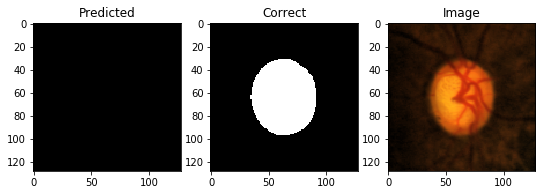

IOU: 0.0
Dice: 0.0
image #1


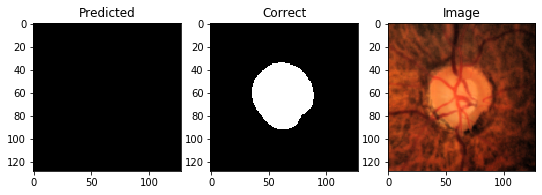

IOU: 0.0
Dice: 0.0
image #2


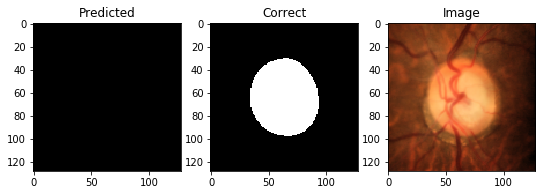

IOU: 0.0
Dice: 0.0
image #3


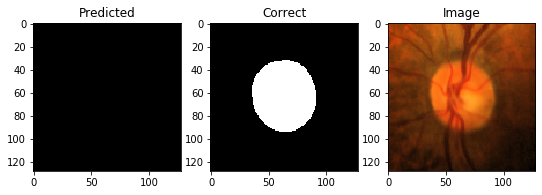

IOU: 0.0
Dice: 0.0
image #4


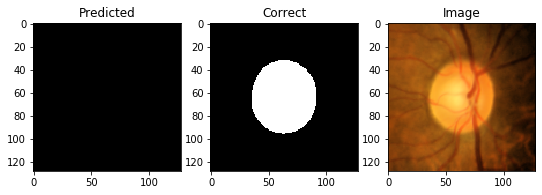

IOU: 0.0
Dice: 0.0
image #5


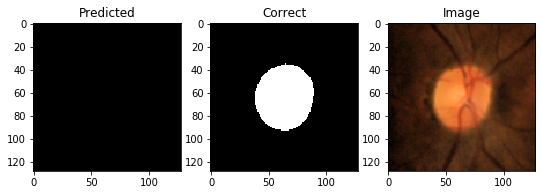

IOU: 0.0
Dice: 0.0
image #6


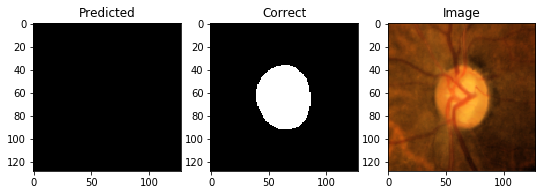

IOU: 0.0
Dice: 0.0
image #7


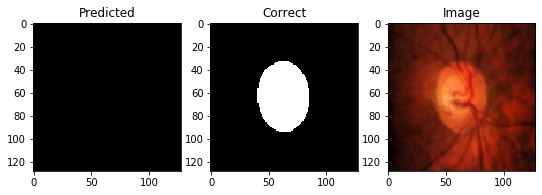

IOU: 0.0
Dice: 0.0
image #8


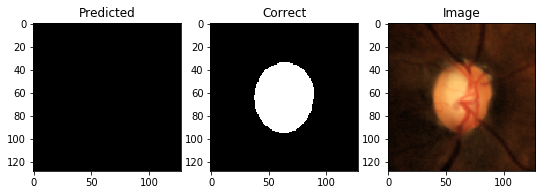

IOU: 0.0
Dice: 0.0
image #9


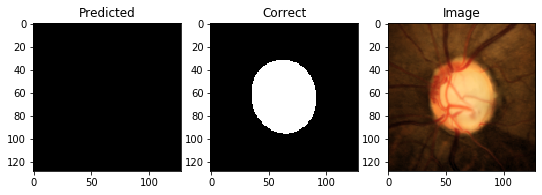

IOU: 0.0
Dice: 0.0
image #10


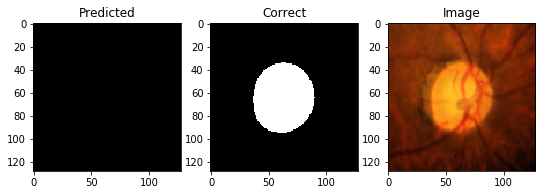

IOU: 0.0
Dice: 0.0
image #11


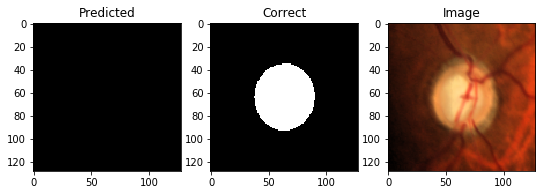

IOU: 0.0
Dice: 0.0
image #12


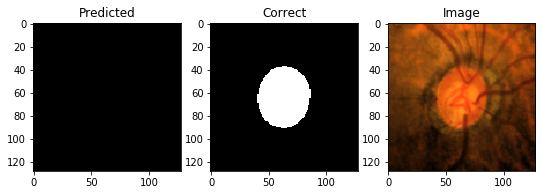

IOU: 0.0
Dice: 0.0
image #13


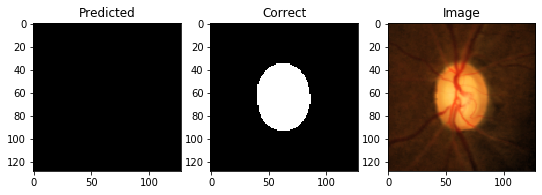

IOU: 0.0
Dice: 0.0
image #14


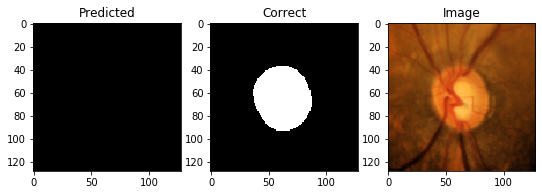

IOU: 0.0
Dice: 0.0
image #15


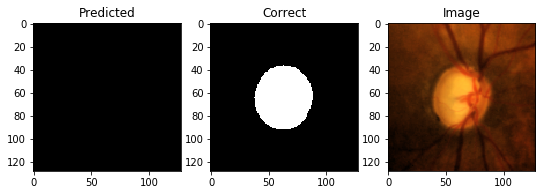

IOU: 0.0
Dice: 0.0
image #16


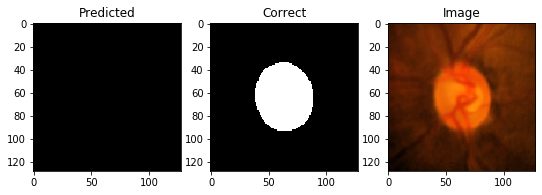

IOU: 0.0
Dice: 0.0
image #17


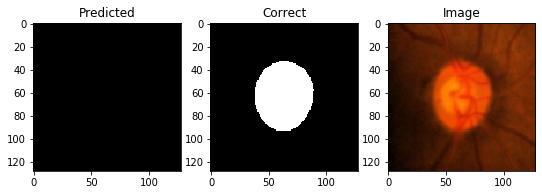

IOU: 0.0
Dice: 0.0
image #18


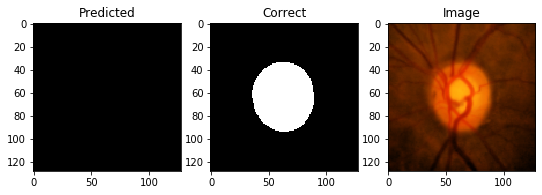

IOU: 0.0
Dice: 0.0
image #19


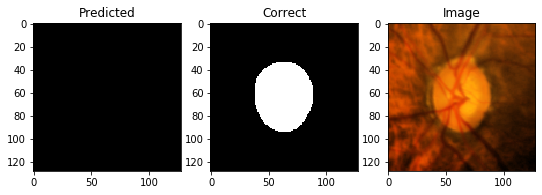

IOU: 0.0
Dice: 0.0
image #20


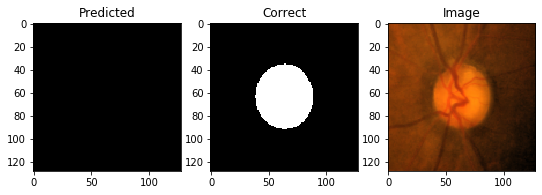

IOU: 0.0
Dice: 0.0
image #21


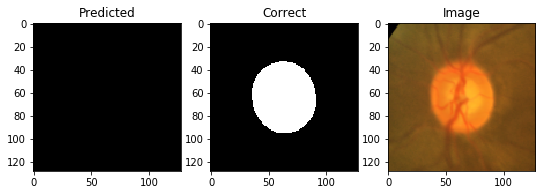

IOU: 0.0
Dice: 0.0
image #22


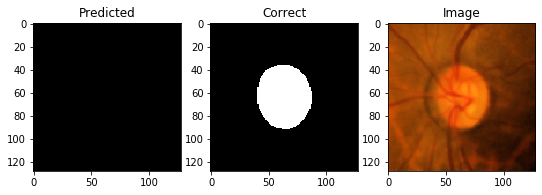

IOU: 0.0
Dice: 0.0
image #23


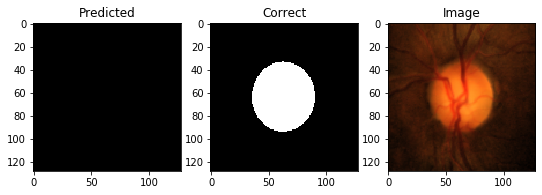

IOU: 0.0
Dice: 0.0
image #24


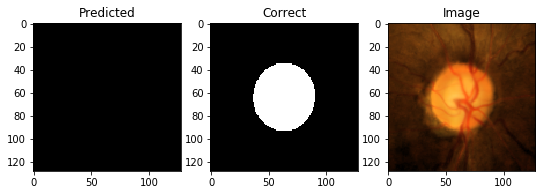

IOU: 0.0
Dice: 0.0
image #25


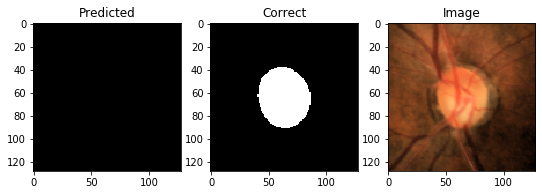

IOU: 0.0
Dice: 0.0
image #26


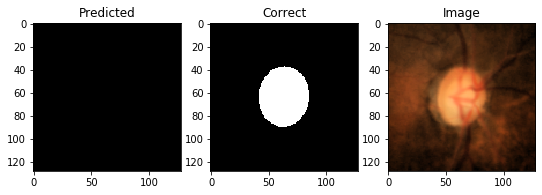

IOU: 0.0
Dice: 0.0
image #27


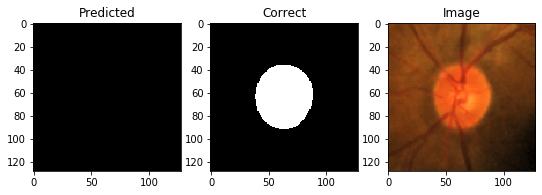

IOU: 0.0
Dice: 0.0
image #28


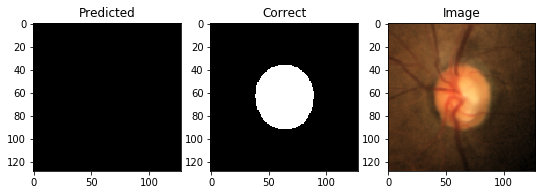

IOU: 0.0
Dice: 0.0
image #29


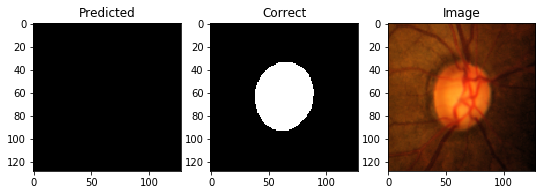

IOU: 0.0
Dice: 0.0
image #30


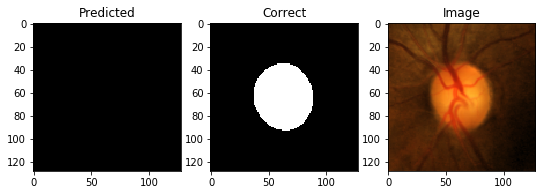

IOU: 0.0
Dice: 0.0
image #31


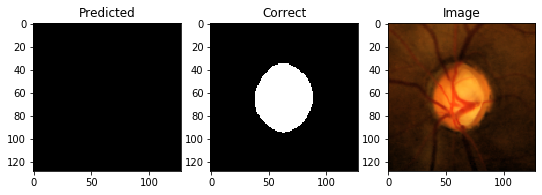

IOU: 0.0
Dice: 0.0
image #32


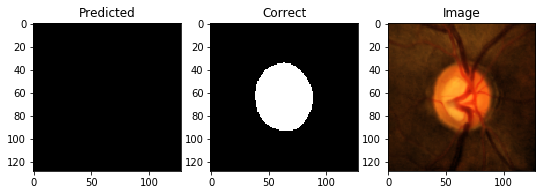

IOU: 0.0
Dice: 0.0
image #33


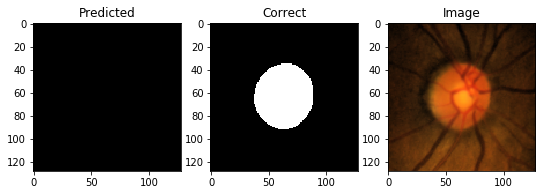

IOU: 0.0
Dice: 0.0
image #34


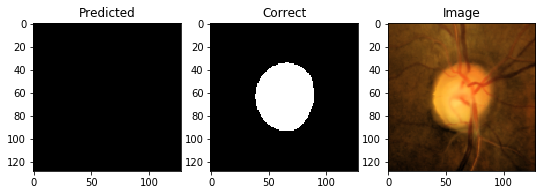

IOU: 0.0
Dice: 0.0
image #35


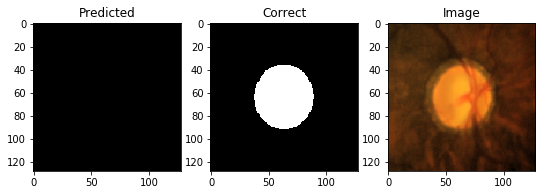

IOU: 0.0
Dice: 0.0
image #36


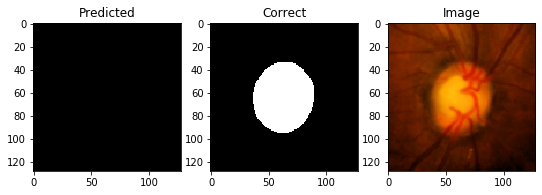

IOU: 0.0
Dice: 0.0
image #37


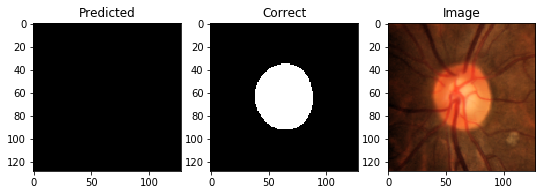

IOU: 0.0
Dice: 0.0
image #38


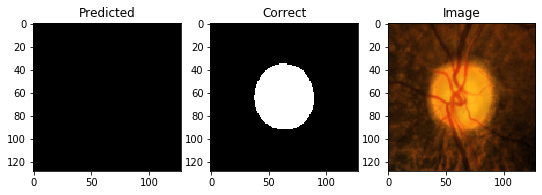

IOU: 0.0
Dice: 0.0
image #39


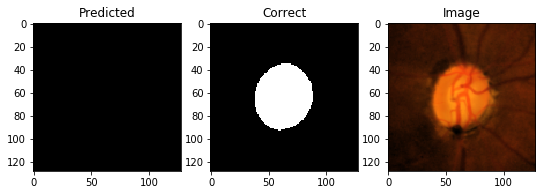

IOU: 0.0
Dice: 0.0
image #40


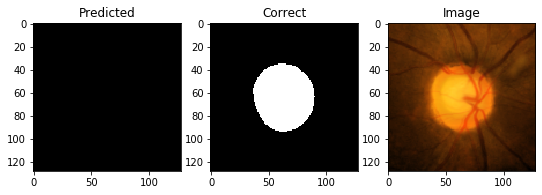

IOU: 0.0
Dice: 0.0
image #41


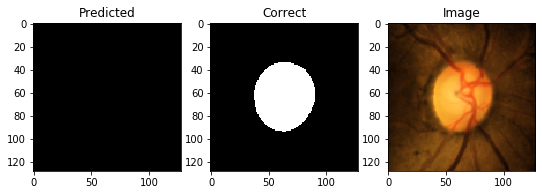

IOU: 0.0
Dice: 0.0
image #42


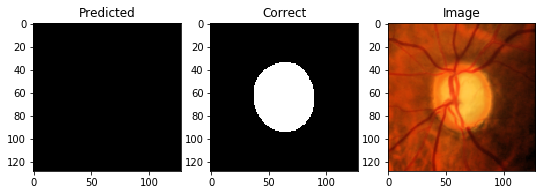

IOU: 0.0
Dice: 0.0
image #43


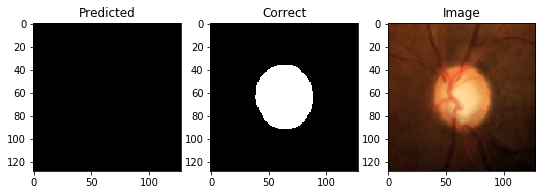

IOU: 0.0
Dice: 0.0
image #44


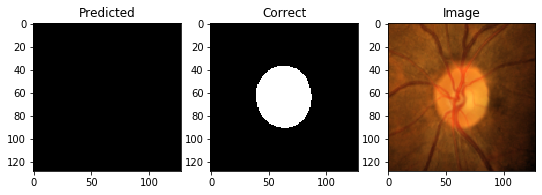

IOU: 0.0
Dice: 0.0
image #45


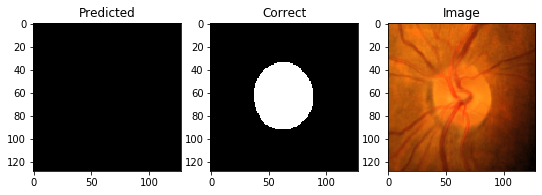

IOU: 0.0
Dice: 0.0
image #46


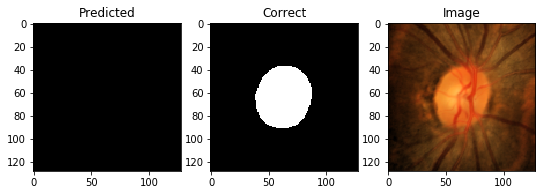

IOU: 0.0
Dice: 0.0
image #47


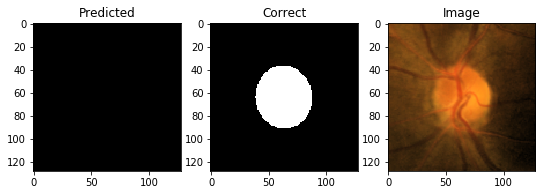

IOU: 0.0
Dice: 0.0
image #48


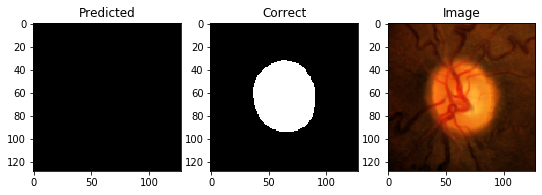

IOU: 0.0
Dice: 0.0
image #49


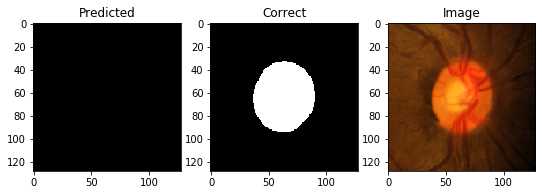

IOU: 0.0
Dice: 0.0


In [71]:
pred_iou, pred_dice = [], []
pred_disc = []

for i, img_no in enumerate(test_idx):
    print('image #{}'.format(img_no))
    img = img_train[img_no]
    batch_X = X_valid[i:i + 1]
    batch_z = Z_valid[i:i + 1]
    
    pred = (model.predict(batch_X)[0, 0] > 0.5).astype(np.float64)
    pred_disc.append(pred)
    corr = th_to_tf_encoding(batch_z)[0, ..., 0]
        
    fig = plt.figure(figsize=(9, 4))
    ax = fig.add_subplot(1, 3, 1)
    ax.imshow(pred, cmap=plt.cm.Greys_r)
    ax.set_title('Predicted')
    ax = fig.add_subplot(1, 3, 2)
    ax.imshow(corr, cmap=plt.cm.Greys_r)
    ax.set_title('Correct')
    ax = fig.add_subplot(1, 3, 3)
    ax.imshow(th_to_tf_encoding(batch_X)[0])
    ax.set_title('Image')
    plt.show()
    
    cur_iou = K.eval(mean_IOU_gpu(pred[None, None, ...], corr[None, None, ...]))
    cur_dice = K.eval(dice(pred[None, None, ...], corr[None, None, ...]))
    print('IOU: {}\nDice: {}'.format(cur_iou, cur_dice))
    pred_iou.append(cur_iou)
    pred_dice.append(cur_dice)

In [37]:
print(np.mean(pred_iou))
print(np.mean(pred_dice))

0.88481957
0.9318124774128806


In [38]:
def ellipseFitting(img):
    contours, hierarchy = cv2.findContours(img.copy(),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
    ellipse = np.zeros(img.shape)
    diametro = []
    for ind, cont in enumerate(contours):
        (x,y),(MA,ma),angle = cv2.fitEllipse(cont)
        diametro.append((MA, ma))
        cv2.ellipse(ellipse,(int(x),int(y)),(int(MA/2), int(ma/2)),angle,0,360,(255,255,255),0)
    return ellipse, diametro

In [39]:
import cv2
cdrs = []
for i, img_no in enumerate(test_idx):
    cup = pred_cup[i]
    disc = pred_disc[i]
        
    c = cv2.Canny(cup.astype(np.uint8), 1,1)
    d = cv2.Canny(disc.astype(np.uint8), 1,1)
    
    el_c, diam_c = ellipseFitting(c)
    el_d, diam_d = ellipseFitting(d)
        
    if len(diam_d) > 0 and len(diam_c) > 0:
        cdr = diam_c[0][1]/diam_d[0][1]
        cdrs.append(cdr)
        print('image #{} - cdr = {}'.format(img_no, cdr))


image #0 - cdr = 0.7959553770044641
image #1 - cdr = 2.5943181844706773
image #2 - cdr = 0.7715123244327965
image #3 - cdr = 0.7152091702221255
image #4 - cdr = 0.7497682447155499
image #5 - cdr = 0.7275174564353213
image #6 - cdr = 0.8467512558832814
image #7 - cdr = 0.4260348274409503
image #8 - cdr = 0.7921016718303348
image #9 - cdr = 0.874442048338831
image #10 - cdr = 0.8320030462049364
image #11 - cdr = 0.8892464849475913
image #12 - cdr = 0.6806354395095642
image #13 - cdr = 0.7861529670340084
image #14 - cdr = 0.7250295149614733
image #15 - cdr = 0.8096947150863838
image #16 - cdr = 0.6951579714638968
image #17 - cdr = 0.6714348657741803
image #18 - cdr = 0.7042569022099471
image #19 - cdr = 0.7697079115555777
image #20 - cdr = 0.7154596743923402
image #21 - cdr = 0.8523058303931974
image #22 - cdr = 0.7416844636420372
image #23 - cdr = 0.726632927331785
image #24 - cdr = 0.8281362809368412
image #25 - cdr = 0.6668022996570586
image #26 - cdr = 0.7939083118706878
image #27 - c